## CSC2515 Fall 2017 Paper by Krist Papadopoulos

### Boston Housing Dataset - Lasso and Random Forest Regression calculations

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.datasets import load_boston

In [2]:
class model(object):
    '''
    model object
    '''
    def __init__(self, clf, version, name, X, y):
        self.regress = clf
        self.version = version
        self.name = name
        self.X = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)
        self.y = y

In [3]:
def model_cross_validation(model, kfold):
    X_train = model.X
    y_train = model.y
    kf = KFold(n_splits=kfold, shuffle=True, random_state = 42)
    predict = []
    cv_mse = []
    for j, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train)):
        cv_X_train, cv_X_test = X_train[cv_train_idx], X_train[cv_test_idx]
        cv_y_train, cv_y_test = y_train[cv_train_idx], y_train[cv_test_idx]   
        
        model.regress.fit(cv_X_train,cv_y_train)
        
        predict.append(model.regress.predict(cv_X_test))
        
        cv_mse.append(mean_squared_error(cv_y_test, model.regress.predict(cv_X_test)))
    
    if model.name == 'lasso':
        lasso_coef = model.regress.coef_
        return np.array(predict), np.array(cv_mse),lasso_coef
    
    elif model.name == 'random':
        random_feat_importance = model.regress.feature_importances_
        return np.array(predict), np.array(cv_mse), random_feat_importance
    
    else:
        pass

# Boston Data

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
len(X)
boston.feature_names
X_df = pd.DataFrame(X, columns=boston.feature_names)
y_df = pd.DataFrame(y, columns=['SALEPRICE'])

506

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='<U7')

In [5]:
df = pd.concat([X_df,y_df], axis=1)

In [20]:
df_filtered = df[df['SALEPRICE'] < 50]

In [21]:
df_filtered.to_csv('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/df_filtered_boston.csv', header=True)

Text(0.5,1,'Correlation Map of Boston Housing Features and Sales Price Target')

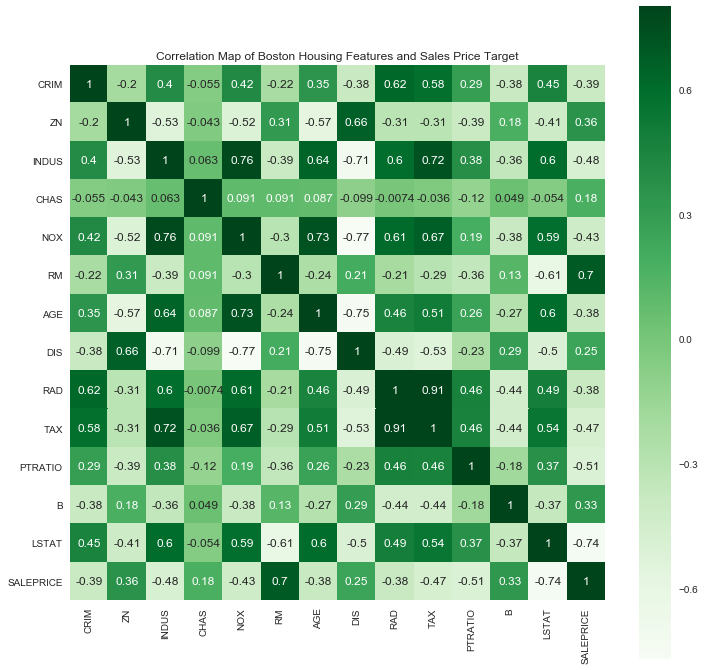

In [8]:
# Correlation Map with no Outlier Filtering

corrmat = pd.concat([X_df,y_df], axis=1).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Greens", annot=True)
plt.title("Correlation Map of Boston Housing Features and Sales Price Target")
plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Lasso_Heat_Map.png', bbox_inches='tight')

Text(0.5,1,'Correlation Map of Boston Housing Features and Sales Price Target with Sale Price of 50 Filtered')

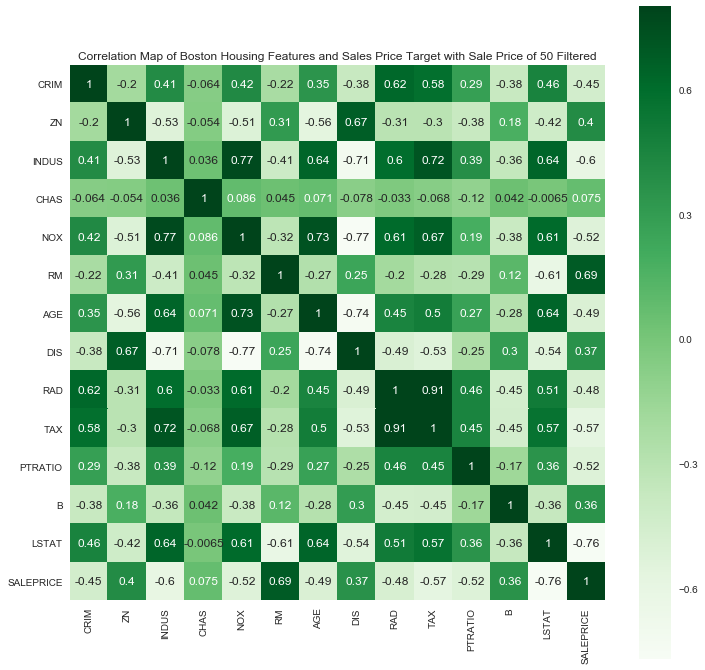

In [88]:
# Correlation Map with Outlier Filtering

corrmat_outlier_filtered = df_filtered.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat_outlier_filtered, vmax=.8, square=True, cmap="Greens", annot=True)
plt.title("Correlation Map of Boston Housing Features and Sales Price Target with Sale Price of 50 Filtered")

# Lasso Model

## No Filtering for Outlier

### Hyperparameter Tuning

In [9]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)
    return mse

In [10]:
# cross validation, alpha regularization
alphas = [0.0001,0.0005,0.001, 0.0025, 0.005, 0.01, 0.02]
cv_lasso = [mse_cv(Lasso(alpha=alpha, max_iter=10000), X, y).mean() for alpha in alphas]
print("The minimum mean squared error is {} and it occurrs at regularization of {}".format(min(cv_lasso),alphas[np.argmin(cv_lasso)]))

The minimum mean squared error is 35.647207954005864 and it occurrs at regularization of 0.02


### Lasso CV Predictions

In [11]:
boston_lasso = model(Lasso(alpha=0.02, selection='random', random_state=42),1,'lasso',X,y)

In [12]:
boston_lasso_1_cv_predict, boston_lasso_1_cv_mse, lasso_coef = model_cross_validation(boston_lasso, 5)

In [13]:
boston_lasso_1_cv_mse

array([ 24.4171315 ,  20.93646096,  26.4896506 ,  23.27309931,  22.30358311])

In [14]:
boston_lasso_1_cv_mse.sum()/5

23.483985097680829

In [48]:
np.std(boston_lasso_1_cv_mse)/np.sqrt(5)

0.84457061857015936

In [15]:
max(boston_lasso_1_cv_mse) - min(boston_lasso_1_cv_mse)

5.5531896441718871

In [16]:
dict(zip(boston.feature_names,lasso_coef))

{'AGE': 0.20450776117103941,
 'B': 0.77586511855106743,
 'CHAS': 0.5857475800136519,
 'CRIM': -0.83972443214617576,
 'DIS': -3.1250279948657123,
 'INDUS': -0.16183808151889817,
 'LSTAT': -3.8795134468069601,
 'NOX': -1.8867040991071078,
 'PTRATIO': -1.9425192977201162,
 'RAD': 2.5567099218976779,
 'RM': 2.5712593092674818,
 'TAX': -2.1847912325014289,
 'ZN': 1.1347744801793103}

Text(0.5,1,'Boston Dataset House Prices Distributions versus Predictions from 5 Fold Lasso CV')

Text(0.5,0,'House Price')

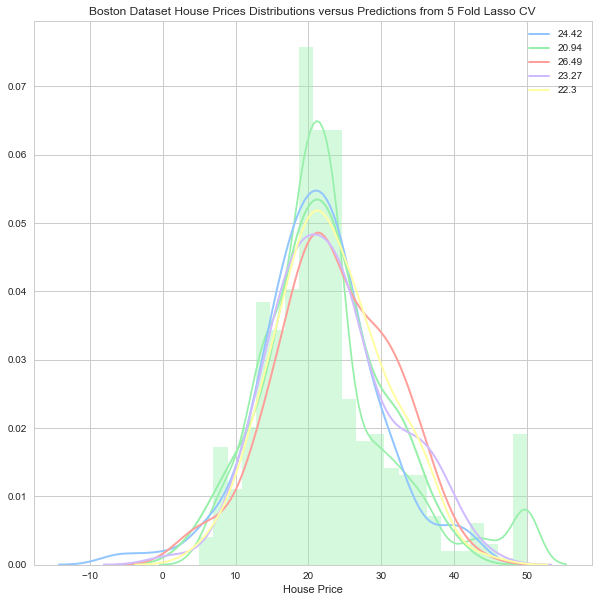

In [32]:
from scipy.stats import norm,lognorm
sns.set(style="whitegrid", palette="pastel", color_codes=True)

plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices Distributions versus Predictions from 5 Fold Lasso CV")
plt.xlabel('House Price')

sns.distplot(y, color='g')

for i,j in zip(range(len(boston_lasso_1_cv_predict)),boston_lasso_1_cv_mse):
    sns.distplot(boston_lasso_1_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

#plt.show()
plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Lasso_CV_Predict.png', bbox_inches='tight')

## Filtered Outlier

### Hyperparameter Tuning

In [22]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)
    return mse

In [23]:
# cross validation, alpha regularization
alphas = [0.0001,0.0005,0.001, 0.0025, 0.005, 0.01, 0.02]
cv_lasso_out = [mse_cv(Lasso(alpha=alpha, max_iter=10000), df_filtered[df_filtered.columns.values[0:-1]], df_filtered[df_filtered.columns.values[-1]]).mean() for alpha in alphas]
print("The minimum mean squared error is {} and it occurrs at regularization of {}".format(min(cv_lasso_out),alphas[np.argmin(cv_lasso_out)]))

The minimum mean squared error is 22.81051732738738 and it occurrs at regularization of 0.01


### Lasso CV Predictons with Outlier Removed

In [24]:
boston_lasso_2 = model(Lasso(alpha=0.01, selection='random', random_state=42),2,'lasso',df_filtered[df_filtered.columns.values[0:-1]].values, df_filtered[df_filtered.columns.values[-1]].values)

In [25]:
boston_lasso_2_cv_predict, boston_lasso_2_cv_mse, lasso_coef_2 = model_cross_validation(boston_lasso_2, 5)

In [26]:
boston_lasso_2_cv_mse

array([ 12.11290412,  19.67893726,  15.09339078,  17.7035323 ,  11.18641088])

In [27]:
boston_lasso_2_cv_mse.sum()/5

15.155035067045713

In [49]:
np.std(boston_lasso_2_cv_mse)/np.sqrt(5)

1.4417887198824808

In [28]:
max(boston_lasso_2_cv_mse)-min(boston_lasso_2_cv_mse)

8.4925263751309963

In [29]:
dict(zip(boston.feature_names,lasso_coef_2))

{'AGE': -0.38476410518701182,
 'B': 0.76700451395035762,
 'CHAS': 0.086905984750919762,
 'CRIM': -0.68918438893237,
 'DIS': -2.4730622409837295,
 'INDUS': -0.19966027823410423,
 'LSTAT': -2.7909077199085544,
 'NOX': -1.5541299518447178,
 'PTRATIO': -1.7930192438572488,
 'RAD': 2.2022908196136548,
 'RM': 2.2979476199837197,
 'TAX': -2.3700979933309969,
 'ZN': 0.74342476293949156}

Text(0.5,1,'Boston Dataset House Prices (Without 50) Distributions versus Predictions from 5 Fold Lasso CV')

Text(0.5,0,'House Price')

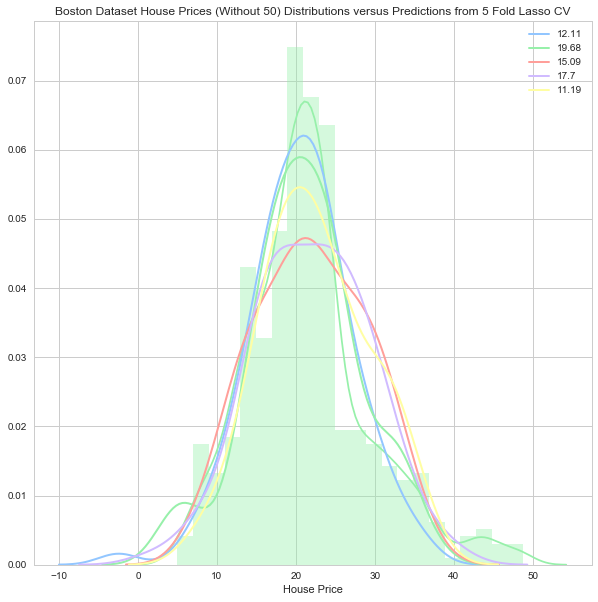

In [31]:
from scipy.stats import norm,lognorm
sns.set(style="whitegrid", palette="pastel", color_codes=True)

plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices (Without 50) Distributions versus Predictions from 5 Fold Lasso CV")
plt.xlabel('House Price')

sns.distplot(df_filtered[df_filtered.columns.values[-1]].values, color='g')

for i,j in zip(range(len(boston_lasso_2_cv_predict)),boston_lasso_2_cv_mse):
    sns.distplot(boston_lasso_2_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

#plt.show()
plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Lasso_CV_Predict_Filtered.png', bbox_inches='tight')

# Random Forest Model

## No Filtering for Outlier

### Hyperparameter Tuning

In [103]:
parameters = {'n_estimators':[200,300,400,500], 'max_features':[1,2,3,4,5,6,7]}
reg2 = RandomForestRegressor()
clf = GridSearchCV(reg2, parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(X,y)
clf.best_params_
-clf.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300, 400, 500], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

{'max_features': 7, 'n_estimators': 500}

18.927024787272778

### Random Forest CV Predictions

In [34]:
boston_rf = model(RandomForestRegressor(n_estimators=500, max_features=7),1,'random',X,y)

In [35]:
boston_rf_1_cv_predict, boston_rf_1_cv_mse, random_features = model_cross_validation(boston_rf, 5)

In [36]:
boston_rf_1_cv_mse

array([  8.57497314,  10.80967119,  13.11373851,   8.7860105 ,   9.23555866])

In [37]:
boston_rf_1_cv_mse.sum()/5

10.10399040018874

In [50]:
np.std(boston_rf_1_cv_mse)/np.sqrt(5)

0.7585699053511411

In [38]:
max(boston_rf_1_cv_mse) - min(boston_rf_1_cv_mse)

4.538765362620877

In [39]:
##dict(zip(boston.feature_names, rf_features))

Text(0.5,1,'Boston Dataset House Prices Distribution Versus Predictions from 5 Fold Random Forest CV')

Text(0.5,0,'House Price')

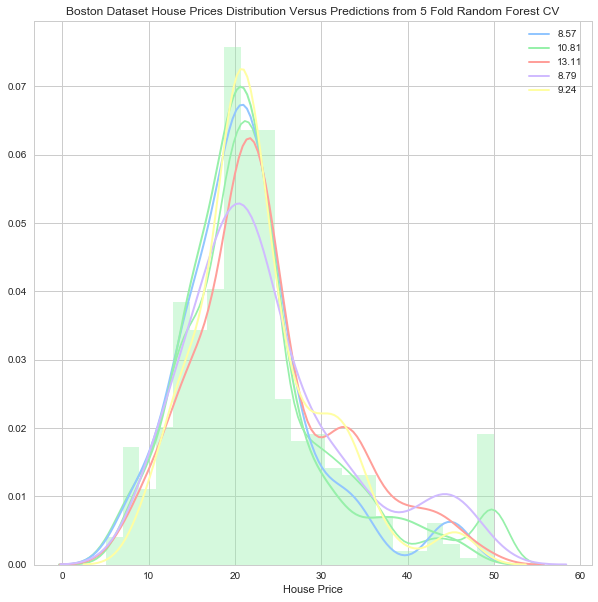

In [40]:
plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices Distribution Versus Predictions from 5 Fold Random Forest CV")
plt.xlabel("House Price")

sns.distplot(y, color='g')

for i,j in zip(range(len(boston_rf_1_cv_predict)), boston_rf_1_cv_mse):
    ax = sns.distplot(boston_rf_1_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

#plt.show()    
plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Random_Forest_CV_Predict.png', bbox_inches='tight')

## Filtering for Outlier

In [114]:
parameters = {'n_estimators':[200,300,400,500], 'max_features':[1,2,3,4,5,6,7]}
reg3 = RandomForestRegressor()
clf = GridSearchCV(reg3, parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(df_filtered[df_filtered.columns.values[0:-1]].values, df_filtered[df_filtered.columns.values[-1]].values)
clf.best_params_
-clf.best_score_

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300, 400, 500], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

{'max_features': 6, 'n_estimators': 400}

14.512655760841886

### Random Forest Predictions without Outlier

In [41]:
boston_rf_2 = model(RandomForestRegressor(n_estimators=400, max_features=6),2,'random',df_filtered[df_filtered.columns.values[0:-1]].values, df_filtered[df_filtered.columns.values[-1]].values)

In [42]:
boston_rf_2_cv_predict, boston_rf_2_cv_mse, random_features_2 = model_cross_validation(boston_rf_2, 5)

In [43]:
boston_rf_2_cv_mse

array([ 5.97753561,  9.25047132,  8.53021151,  7.71917618,  5.22584157])

In [44]:
boston_rf_2_cv_mse.sum()/5

7.3406472383928563

In [51]:
np.std(boston_rf_2_cv_mse)/np.sqrt(5)

0.67930115938583502

In [45]:
max(boston_rf_2_cv_mse) - min(boston_rf_2_cv_mse)

4.0246297448979291

In [46]:
##dict(zip(boston.feature_names,rf_features))

Text(0.5,1,'Boston Dataset House Prices (Without 50) Distribution Versus Predictions from 5 Fold Random Forest CV')

Text(0.5,0,'House Price')

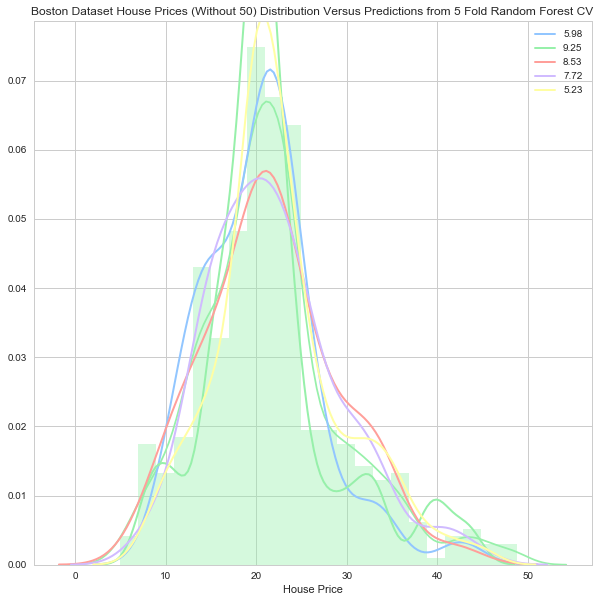

In [47]:
plt.figure(figsize=(10,10))
plt.title("Boston Dataset House Prices (Without 50) Distribution Versus Predictions from 5 Fold Random Forest CV")
plt.xlabel("House Price")

sns.distplot(df_filtered[df_filtered.columns.values[-1]].values, color='g')

for i,j in zip(range(len(boston_rf_2_cv_predict)), boston_rf_2_cv_mse):
    ax = sns.distplot(boston_rf_2_cv_predict[i], hist=False, kde_kws={"lw": 2, "label": round(j,2)})

#plt.show()    
plt.savefig('/Users/KP/Desktop/UfT/CSC2515_Fall_2017/Project/Boston/Boston_Experiments/0-Boston-Lasso-Random_Forest/Boston_Random_Forest_CV_Predict_filtered.png', bbox_inches='tight')